In [169]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

In [170]:
df = pd.read_csv('../data/application_train.csv', index_col=0)
test_df = pd.read_csv('../data/application_test.csv', index_col=0)
df = pd.concat([df,test_df]).reset_index()

In [171]:
df.head()

,index,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_CURR
0,0,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,278621
1,1,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,139008
2,2,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,138348
3,3,0.0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,64140
4,4,0.0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,219374


In [172]:
def display_missing_data_info(dataframe):
    missing_values_count = dataframe.isnull().sum()
    missing_values_percentage = (dataframe.isnull().mean() * 100)
    missing_data = pd.DataFrame({
        'Missing Values': missing_values_count,
        'Percentage (%)': missing_values_percentage
    })
    
    missing_data = missing_data[missing_data['Missing Values'] > 0]
    
    sorted_missing_data = missing_data.sort_values(by='Missing Values')

    print(sorted_missing_data)
    
display_missing_data_info(df)


                          Missing Values  Percentage (%)
DAYS_LAST_PHONE_CHANGE                 1        0.000325
CNT_FAM_MEMBERS                        2        0.000650
AMT_ANNUITY                           12        0.003902
AMT_GOODS_PRICE                      278        0.090403
EXT_SOURCE_2                         660        0.214626
...                                  ...             ...
NONLIVINGAPARTMENTS_MODE          213514       69.432963
NONLIVINGAPARTMENTS_AVG           213514       69.432963
COMMONAREA_AVG                    214865       69.872297
COMMONAREA_MODE                   214865       69.872297
COMMONAREA_MEDI                   214865       69.872297

[68 rows x 2 columns]


In [177]:
def plot_count_by_target_bar(df, columns, target):
    for col in columns:
        plt.figure(figsize=(10, 6)) 
        sns.countplot(data=df, x=col, hue=target)
        plt.xticks(rotation=45)
        plt.title(f'Count of {col} by {target}')
        plt.legend(title=target)
        plt.show()

In [173]:
df['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

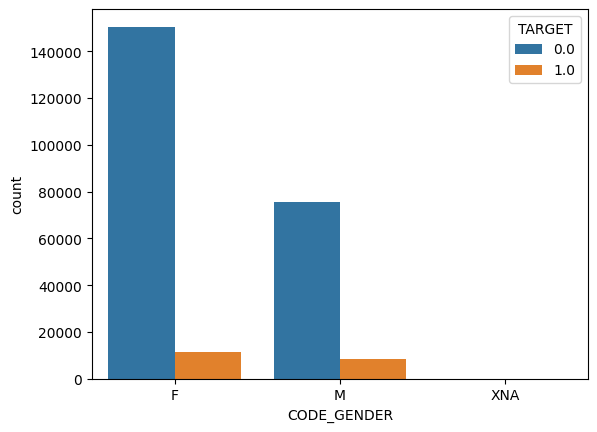

In [174]:
sns.countplot(data=df, x='CODE_GENDER', hue = 'TARGET');

+ The number of females (F) is significantly higher than males (M).
+ Both genders have a much higher number of individuals with no debt (TARGET 0) compared to those with debt (TARGET 1).
+ There is a very small number of individuals with gender labeled as 'XNA,' which could be undefined data.

In [175]:
df['CODE_GENDER'].replace('XNA', 'F', inplace=True)

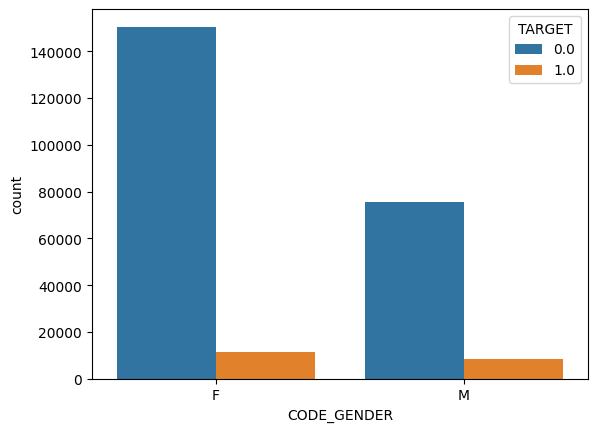

In [176]:
sns.countplot(data=df, x='CODE_GENDER', hue = 'TARGET');

The information is not affected after replacing the 'XNA' values with 'F'

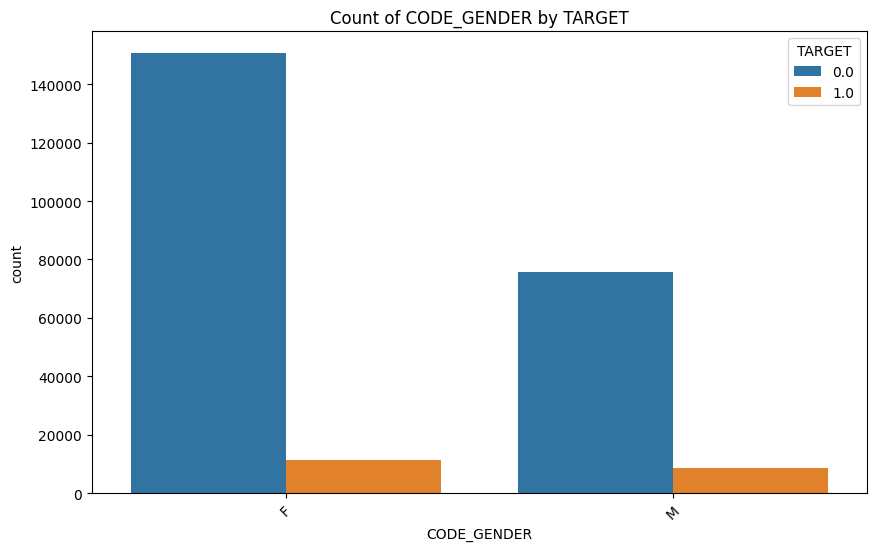

In [178]:
columns_to_plot = ['CODE_GENDER']
plot_count_by_target_bar(df, columns_to_plot, 'TARGET')

In [179]:
def label_encode_columns(df, columns):
    lbe = LabelEncoder()
    for col in columns:
        df[col] = lbe.fit_transform(df[col])
    return df

In [180]:
columns_to_encode = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
df = label_encode_columns(df, columns_to_encode)

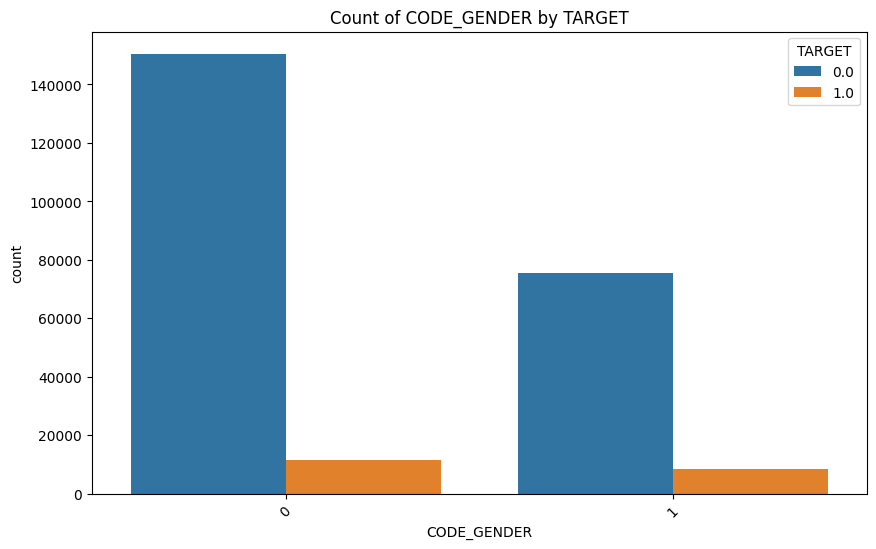

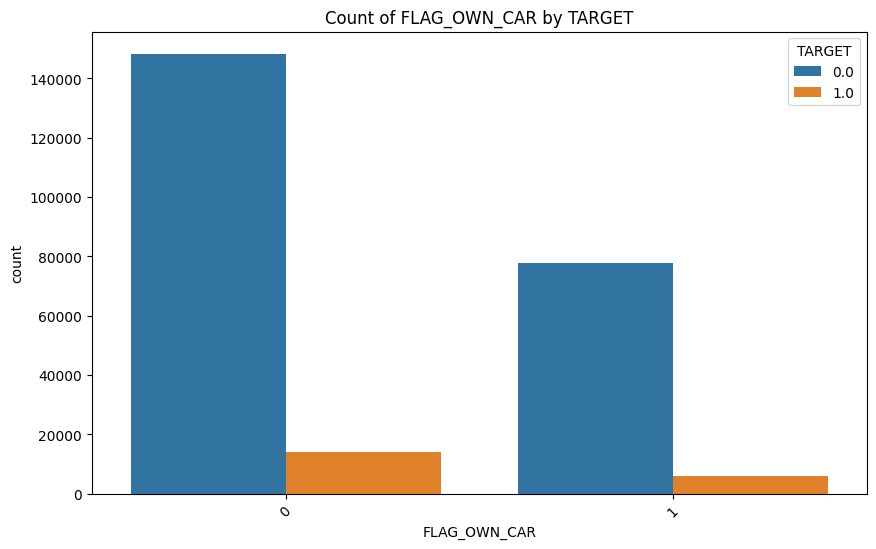

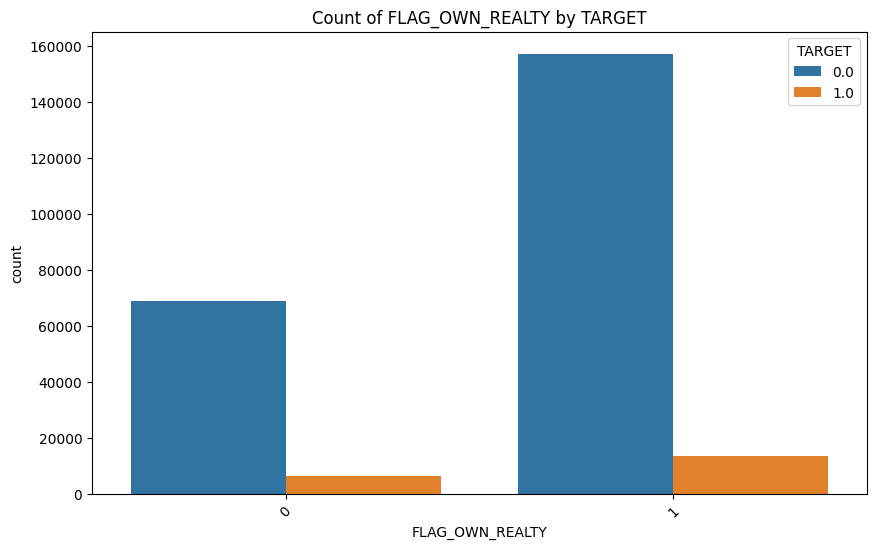

In [181]:
columns_to_plot = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
plot_count_by_target_bar(df, columns_to_plot, 'TARGET')

* FLAG_OWN_CAR:
    + Customers who do not own cars significantly outnumber those who do, which may indicate that car ownership is not the most common criterion in the customer database.
    + The distribution between the group with debt and the group without debt in both subgroups (those with cars and those without cars) shows that there is a low proportion of customers in debt in both groups, but this proportion seems slightly lower among car owners.
    
    => Car ownership may not be a strong indicator of a customer's likelihood to default on a loan, but it can still provide some useful information when combined with other factors in the model.

* FLAG_OWN_REALTY:
    + There is a significantly larger number of customers who own real estate compared to those who do not. Therefore, real estate ownership is common in database
    + The default rate in the group without real estate ownership appears to be slightly higher than in the group with real estate ownership.4

    => The lack of real estate ownership can be associated with a higher financial risk, which may increase the likelihood of defaulting on a loan.

In [182]:
def plot_count_by_target_barh(df, columns, target):
    for col in columns:
        plt.figure(figsize=(9, 6)) 
        order = df[col].value_counts().index
        sns.countplot(data=df, y=col, hue=target, order=order)
        plt.xlabel('Count')
        plt.ylabel(col)
        plt.title(f'Count of {col} by {target}')
        plt.legend(title=target)
        plt.show()

In [183]:
def plot_distribution_by_target(data, column, target_column ='TARGET'):
    plt.figure(figsize=(10, 8))
    
    sns.kdeplot(data.loc[data[target_column] == 0, column], label=f'{target_column} == 0', color='blue')
    sns.kdeplot(data.loc[data[target_column] == 1, column], label=f'{target_column} == 1', color='red')
    
    x_label = column
    
    plt.xlabel(x_label)
    plt.ylabel('Density')
    plt.title(f'Distribution of {x_label}')
    plt.legend()
    plt.show()

In [184]:
def plot_bad_rate_trend(data, column, num_bins=5):
    data['RATIO_BIN'] = pd.qcut(data[column], num_bins)

    bad_rate = data.groupby('RATIO_BIN')['TARGET'].mean()

    plt.figure(figsize=(10, 6))
    bad_rate.plot(kind='line', marker='o')
    plt.title('Bad Rate by Bin')
    plt.xlabel('Bin')
    plt.ylabel('Bad Rate')
    plt.xticks(range(len(bad_rate)), labels=bad_rate.index)
    plt.grid(True)
    plt.show()

    print("Numerical analysis of the trend:")
    print(bad_rate.diff())

In [185]:
def plot_histogram(data, column, hue="TARGET", bins=None, kde=True):
    if bins is None:
        num_bins = int(1 + np.log2(len(data)))
    else:
        num_bins = bins
    sns.histplot(data=data, x=column, hue=hue, bins=num_bins, kde=kde)

In [186]:
education_type_mapping = {
        'Lower secondary': 1,
        'Secondary / secondary special': 2,
        'Incomplete higher': 3,
        'Higher education': 4,
        'Academic degree': 5
    }
df['NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].replace(education_type_mapping)
df['NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].astype('int')

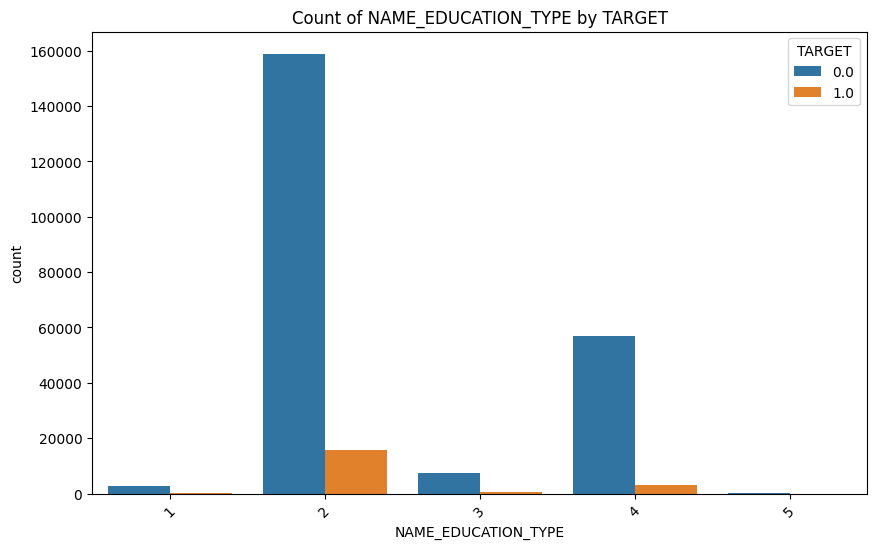

In [187]:
columns_to_plot = ['NAME_EDUCATION_TYPE']
plot_count_by_target_bar(df, columns_to_plot, 'TARGET')

* NAME_EDUCATION_TYPE:
    + The majority of customers in the data share the same type of education (Secondary / Secondary Special). 
    + The number of customers who do not default on their debt (TARGET 0.0) is significantly higher than those who default on their debt (TARGET 1.0) in each education category.

In [188]:
def group_organizations(org_type):
        if 'Trade' in org_type:
            return 'Trade'
        elif 'Industry' in org_type:
            return 'Industry'
        elif 'Business' in org_type:
            return 'Business Entity'
        elif 'Transport' in org_type:
            return 'Transport'
        else:
            return org_type
df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].apply(group_organizations)

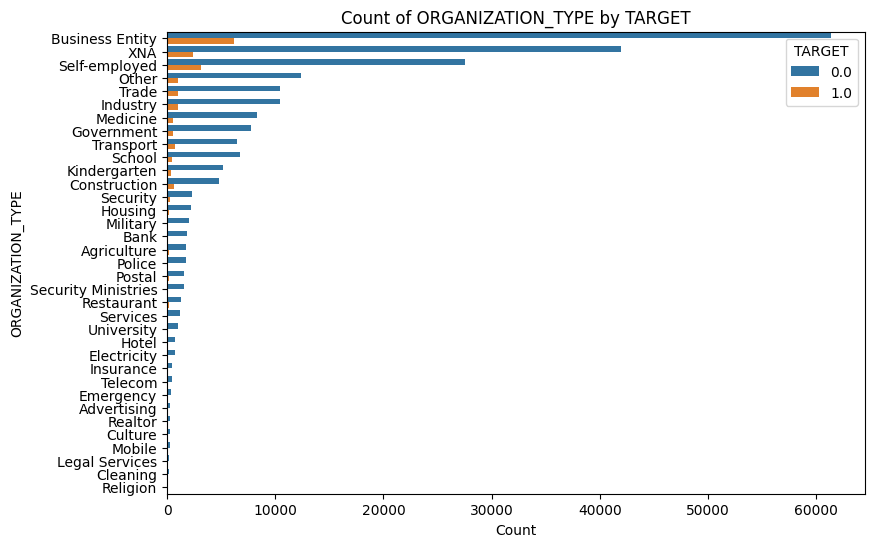

In [189]:
columns_to_plot = [ 'ORGANIZATION_TYPE']

plot_count_by_target_barh(df, columns_to_plot, 'TARGET')

* ORGANIZATION TYPE:
    + The data includes customers from various industries.
    + Some industries like 'Business Entity,' 'School,' and 'Religion' have a high number of customers, while others like 'Legal Services,' 'Cleaning,' and 'Telecom' have fewer customers. 
    + There is also a significant number of customers categorized under 'XNA,' which may indicate that they either do not provide information about their employer or this information is unavailable.
    + In each industry, the proportion of customers who do not default on their debt (TARGET 0.0) is consistently higher than those who do default on their debt (TARGET 1.0).

In [190]:
#calculate a financial burden ratio for each combination of organization type and education type 
med_income = df.groupby(['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE'])['AMT_INCOME_TOTAL'].transform('median')

# to measure the financial burden of monthly payments relative to the average income of borrowers, 
df['true_annuity_div_income'] = df['AMT_ANNUITY'] / med_income

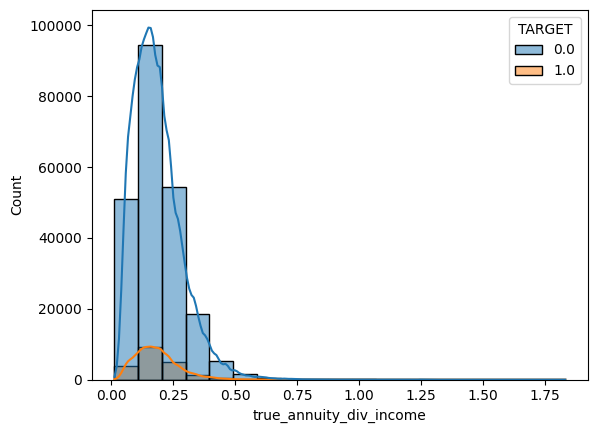

In [191]:
plot_histogram(df, 'true_annuity_div_income')

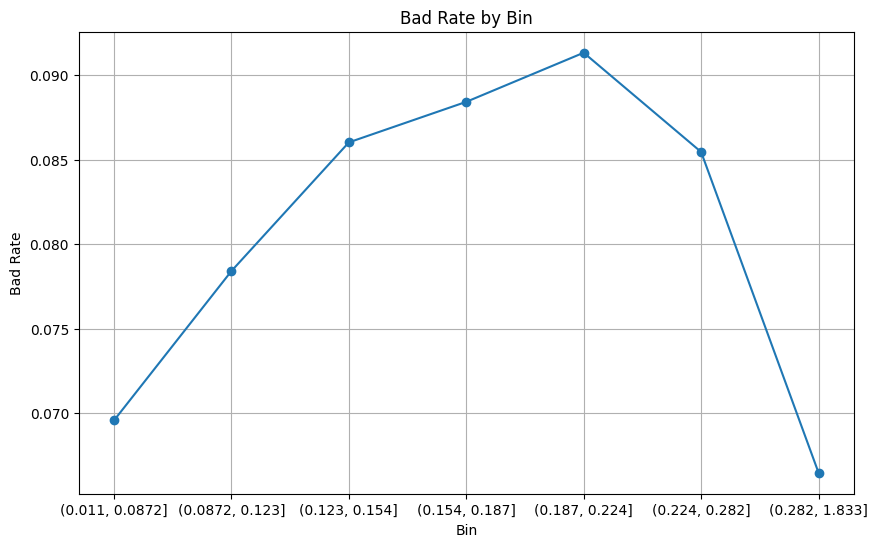

Numerical analysis of the trend:
RATIO_BIN
(0.011, 0.0872]         NaN
(0.0872, 0.123]    0.008847
(0.123, 0.154]     0.007621
(0.154, 0.187]     0.002402
(0.187, 0.224]     0.002909
(0.224, 0.282]    -0.005878
(0.282, 1.833]    -0.019000
Name: TARGET, dtype: float64


In [192]:
plot_bad_rate_trend(df, 'true_annuity_div_income', 7)

# true_annuity_div_income:

+ The loan default rate gradually increases from approximately the lowest point (0.011, 0.0872) to the range (0.154, 0.187). Afterward, this rate starts to decrease slightly in the next range (0.187, 0.224).

+ There is a sudden increase in the loan default rate in the range (0.154, 0.187) compared to neighboring ranges.

+ The loan default rate decreases significantly in the highest value range (0.282, 1.833). This could indicate that customers in this range may have better financial capabilities to manage their debt, or they may choose loan products with more favorable conditions.

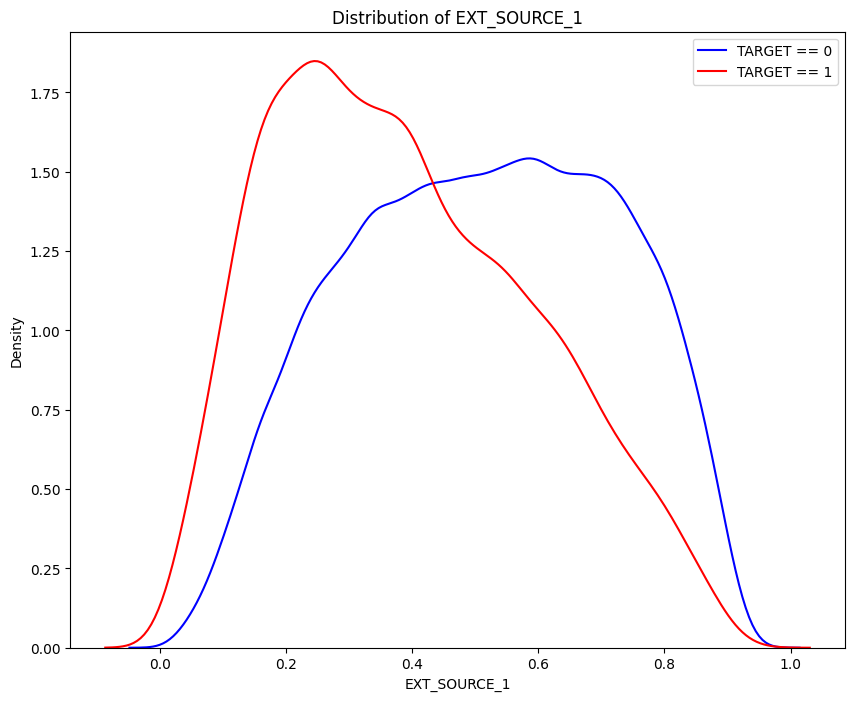

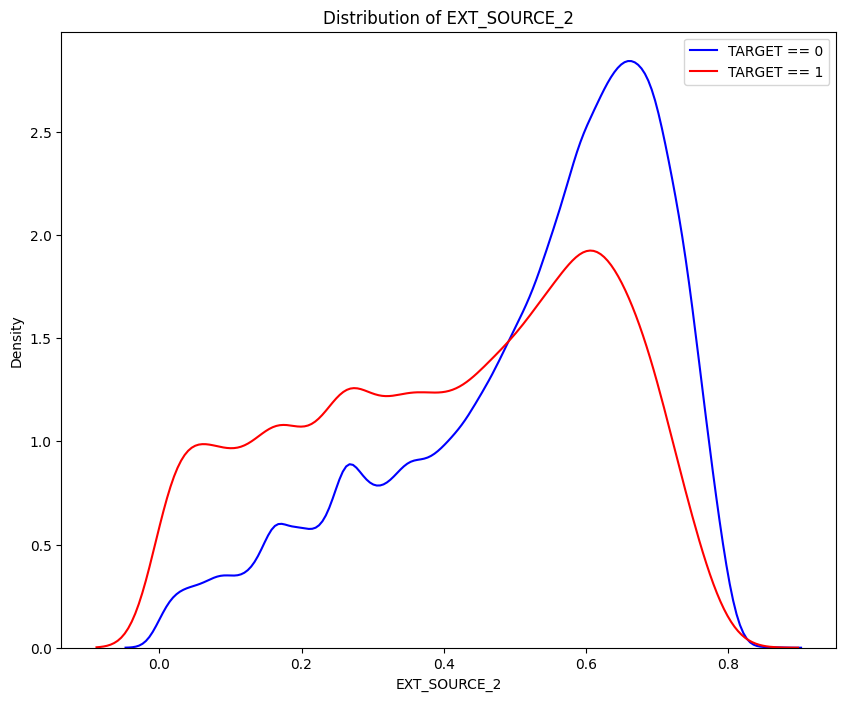

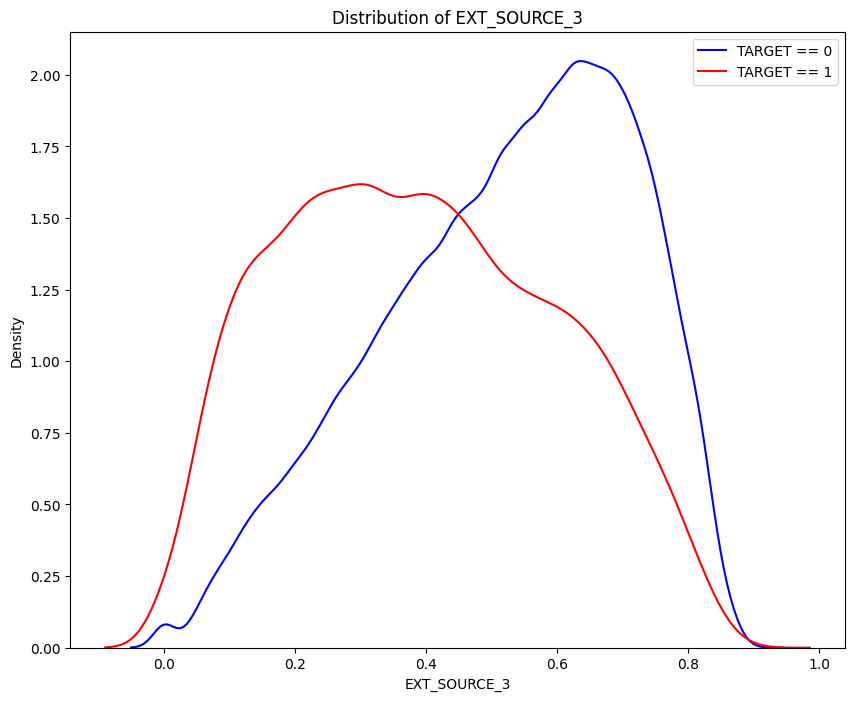

In [193]:
columns = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
for column in columns:
    plot_distribution_by_target(df, column)

# 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3

+ All three charts demonstrate that the non-default group tends to have higher scores from the EXT_SOURCE compared to the default group.

+ However, each source has different distribution characteristics => They may provide additional information to complement each other when assessing a customer's financial capability.

In [194]:
df['EXT_SOURCE_WEIGHTED'] = df['EXT_SOURCE_1'] * 2 + df['EXT_SOURCE_2'] * 3 + df['EXT_SOURCE_3'] * 4
df['EXT_SOURCE_SUM'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].sum(axis=1, skipna=True)
df['EXT_SOURCE_PROD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].prod(axis=1, skipna=True)
df['EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1, skipna=True)
# df['EXT_SOURCE_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1, skipna=True)
df['EXT_SOURCE_MAX'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].max(axis=1, skipna=True)
df['EXT_SOURCE_MIN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].min(axis=1, skipna=True)

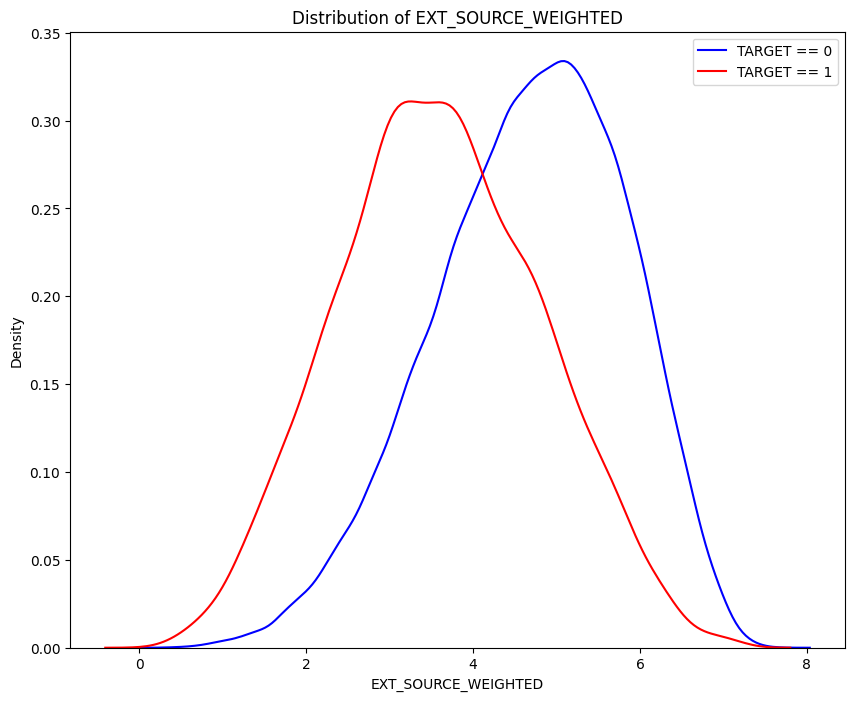

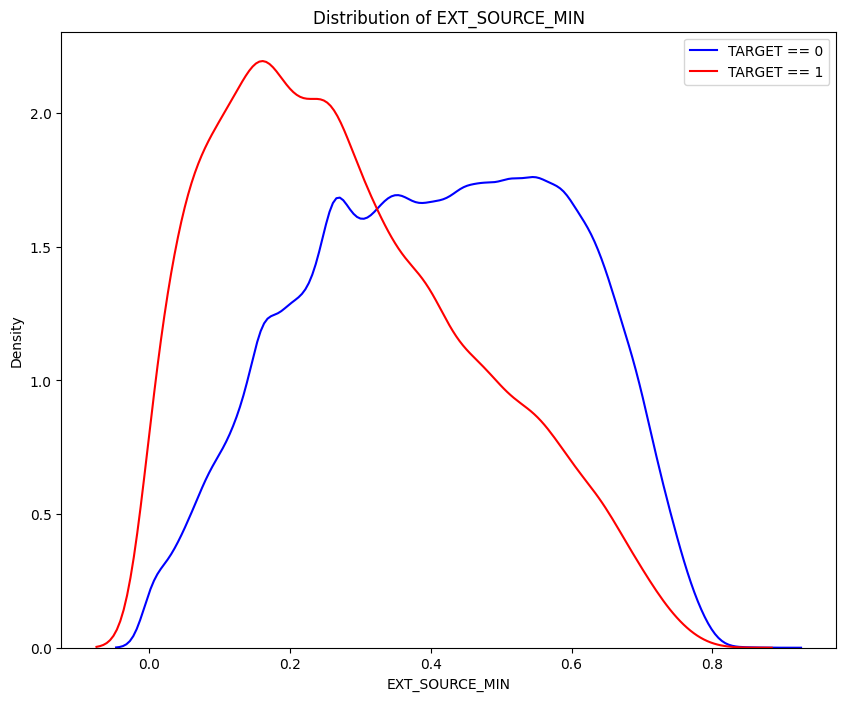

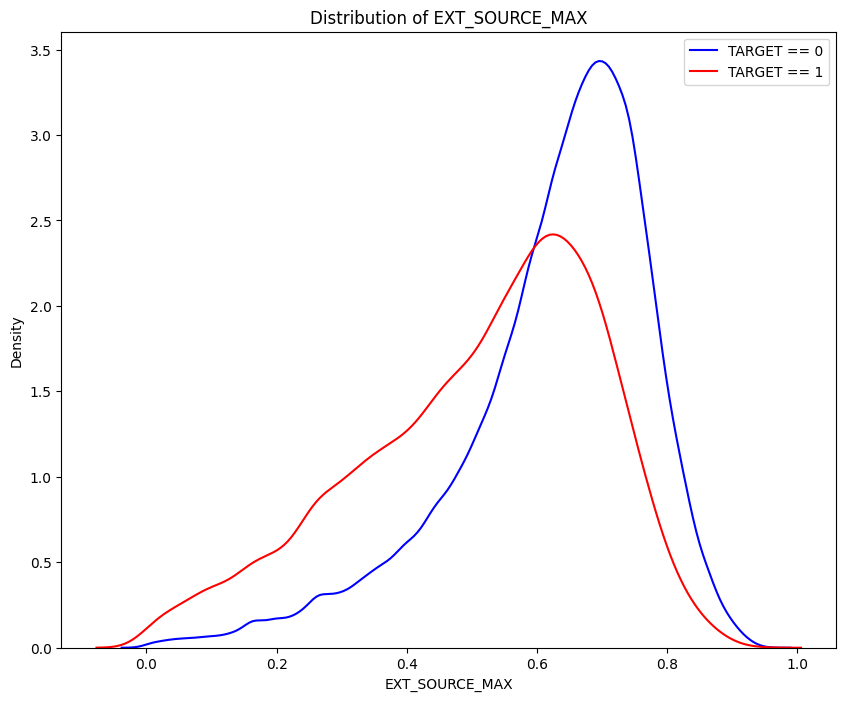

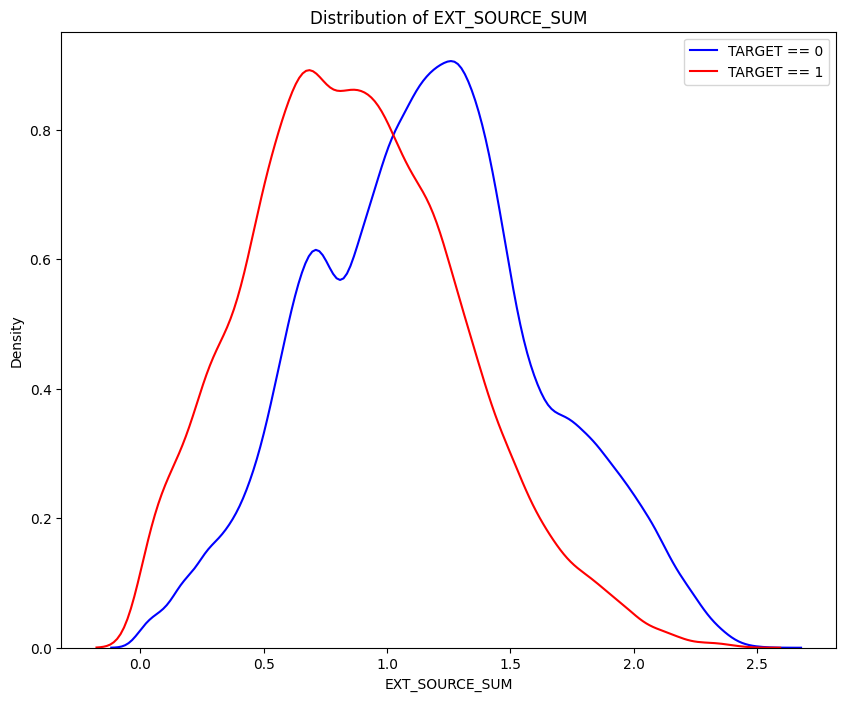

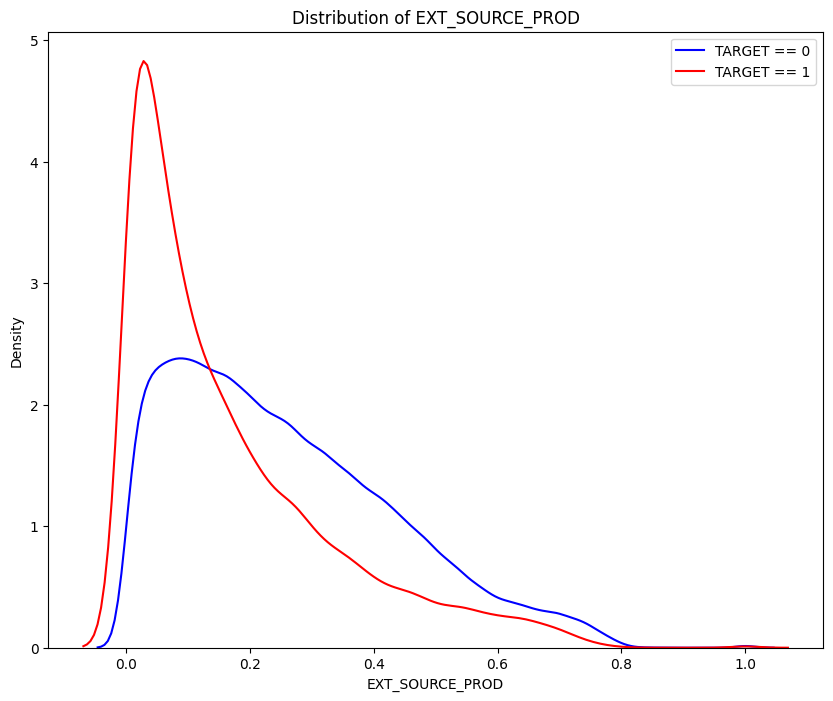

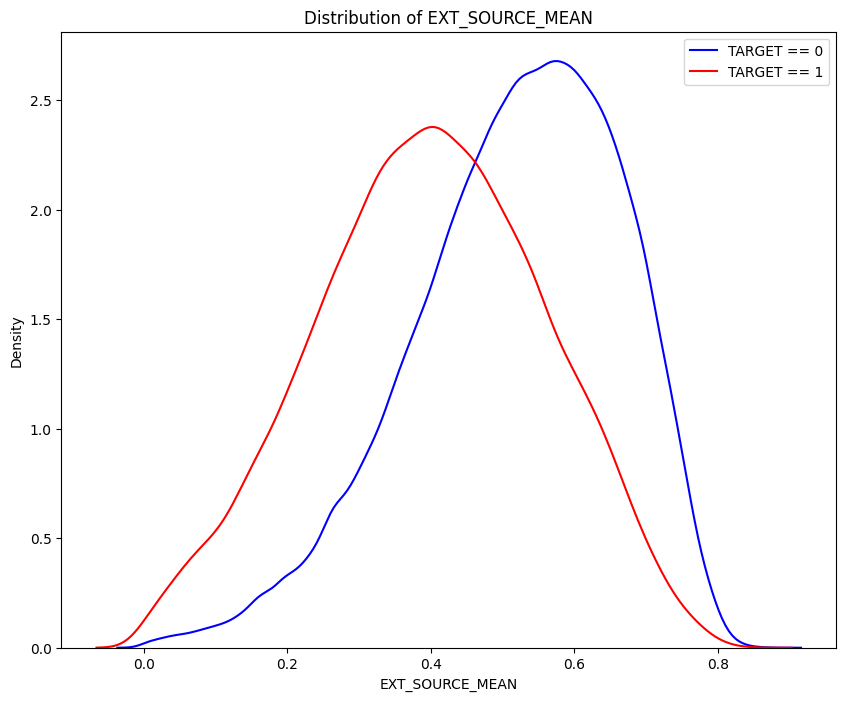

In [195]:
columns = ['EXT_SOURCE_WEIGHTED','EXT_SOURCE_MIN', 'EXT_SOURCE_MAX', 
           'EXT_SOURCE_SUM', 'EXT_SOURCE_PROD', 'EXT_SOURCE_MEAN']
for col in columns:
    plot_distribution_by_target(df, col)

In [196]:
# df['AMT_CREDIT'] = np.sqrt(df['AMT_CREDIT']) 
# plot_histogram(df, 'AMT_CREDIT')

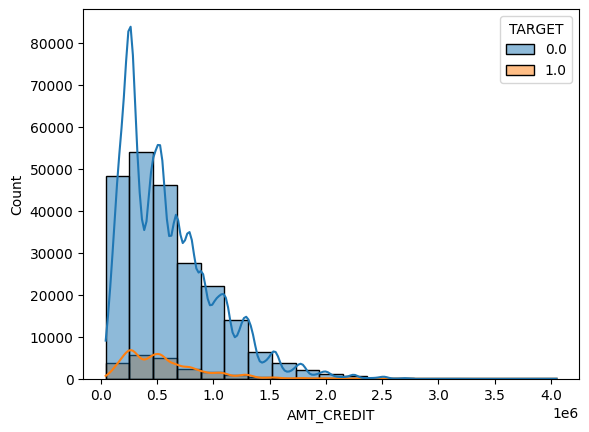

In [197]:
plot_histogram(df, 'AMT_CREDIT')

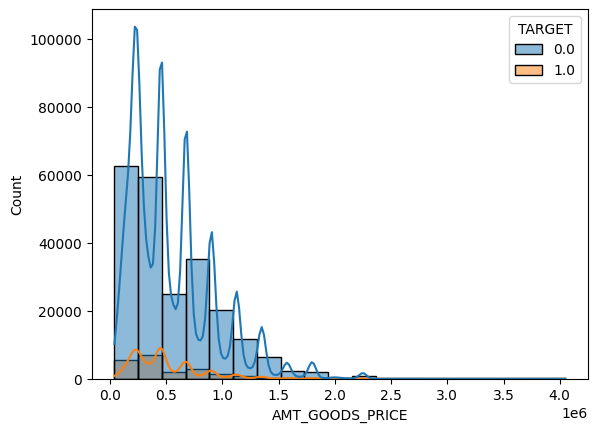

In [198]:
plot_histogram(df, 'AMT_GOODS_PRICE')

# AMT_CREDIT 

    + The distribution of both TARGET groups shows a peak at lower values and decreases as the value increases. This may suggest that as the loan amount increases, the number of borrowers decreases.

    + The TARGET = 0 group has a significantly higher number of loans compared to the TARGET = 1 group at most loan amount levels, indicating that the default rate does not significantly increase with higher loan amounts.

# AMT_GOODS_PRICE


    + Similar to AMT_CREDIT, this distribution has a peak at the lower end and decreases as the value increases, reflecting that transactions with lower commodity values are more common. 

    + The distribution of the non-default group has a higher quantity at low value levels and decreases similarly to the default group. The difference between the two groups is not as clear as in AMT_CREDIT, but it can still be seen that the non-default group dominates at each commodity value point. 

=> Both charts show that smaller loan amounts are more common and that the number of loans decreases exponentially as the amount increases.

In [199]:
#  This feature represents the percentage ratio of the loan amount exceeding the value of the purchased item:
df['CREDIT_GOODS_PRICE_RATIO1'] = (df['AMT_CREDIT'] - df['AMT_GOODS_PRICE']) /  df['AMT_GOODS_PRICE']

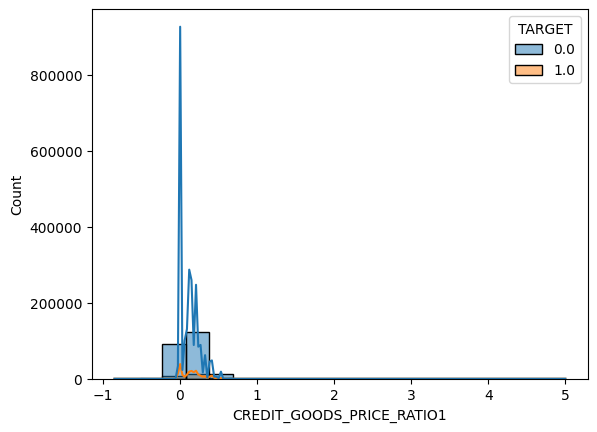

In [200]:
plot_histogram(df, 'CREDIT_GOODS_PRICE_RATIO1')

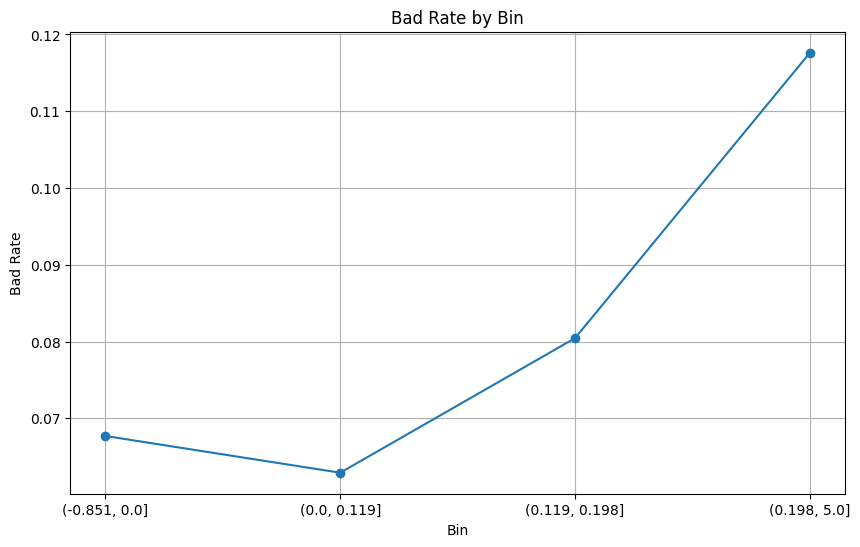

Numerical analysis of the trend:
RATIO_BIN
(-0.851, 0.0]          NaN
(0.0, 0.119]     -0.004788
(0.119, 0.198]    0.017537
(0.198, 5.0]      0.037182
Name: TARGET, dtype: float64


In [201]:
plot_bad_rate_trend(df, 'CREDIT_GOODS_PRICE_RATIO1', num_bins=4)


# 'CREDIT_GOODS_PRICE_RATIO1'
+ The graph has a quite clear trend starting from level 1, the larger the value of this variable, the worse it is



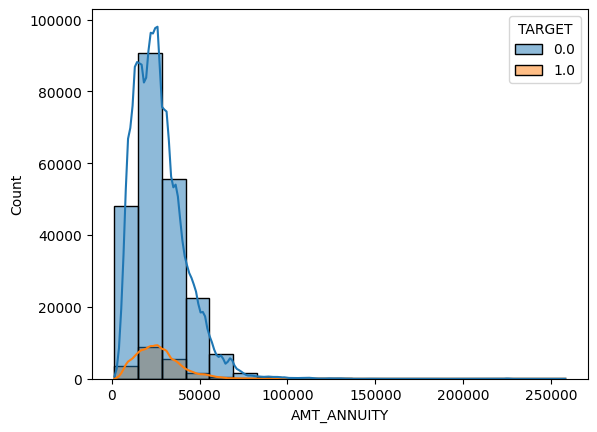

In [202]:
plot_histogram(df, 'AMT_ANNUITY')

# AMT_ANNUITY

+ The distribution of AMT_ANNUITY for both groups tends to concentrate more at low values, with a clear peak at the lower end of the horizontal axis. This suggests that most loans have lower annual installment amounts.

+ The number of annual installment payments significantly decreases as the installment amount increases, which may reflect the availability of larger loans or the borrower's ability to make higher payments.

+ The non-default group (TARGET = 0) has a significantly higher number of annual installment payments than the default group (TARGET = 1) at most value levels, which may reflect better payment ability or more careful financial management.

+ For the default group (TARGET = 1), the number tends to decrease more rapidly than the non-default group as the installment amount increases, indicating a relationship between higher annual installment payments and weaker financial capacity.

In [203]:
# assess the borrower's ability to repay, 
# if this ratio is high, it means that the borrower has to pay a significant amount each month compared to the amount borrowed, which can create financial pressure on them.
df['NEW_PAYMENT_RATE']= df['AMT_CREDIT'] / df['AMT_ANNUITY']

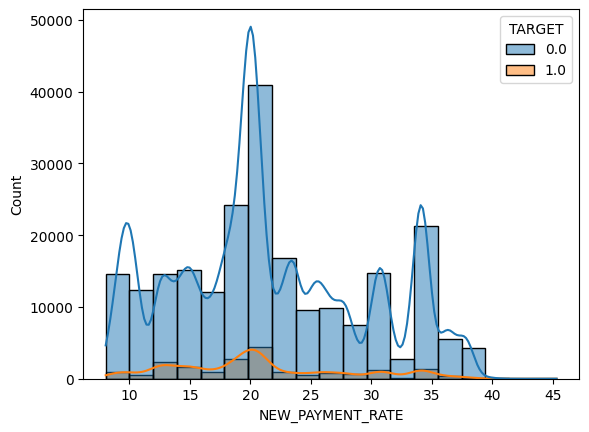

In [204]:
plot_histogram(df, 'NEW_PAYMENT_RATE')

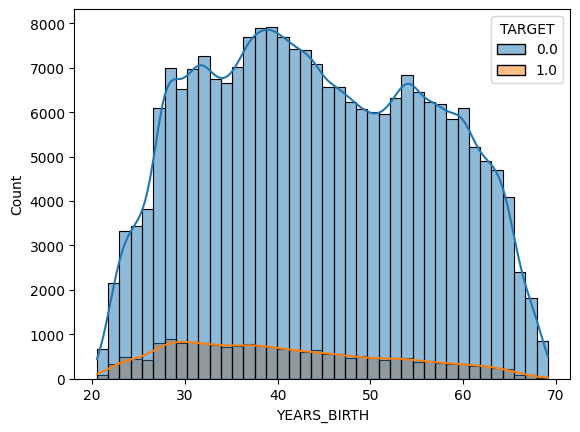

In [205]:
df['YEARS_BIRTH'] = abs(df['DAYS_BIRTH']/365)
plot_histogram(df, 'YEARS_BIRTH', bins=40)

# YEARS_BIRTH

+ The age range of customers falls between 20 and 70 years old.
+ The green line tends not to deviate to either side, while the orange line is significantly lower at every point and tends to deviate to the left.


=> People with lower ages are more likely to default on their debts.

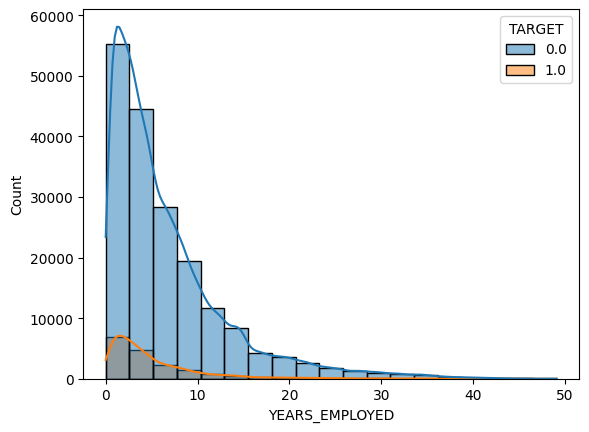

In [206]:
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)
df['YEARS_EMPLOYED'] = abs(df['DAYS_EMPLOYED']/365)
plot_histogram(df, 'YEARS_EMPLOYED')

# YEARS_EMPLOYED:

+ The majority of customers have relatively short working experience; they are all new employees.

+ Based on the orange line, it can be observed that customers who have worked for less than six months are more likely to default on their debts compared to those who have been employed for a longer period.

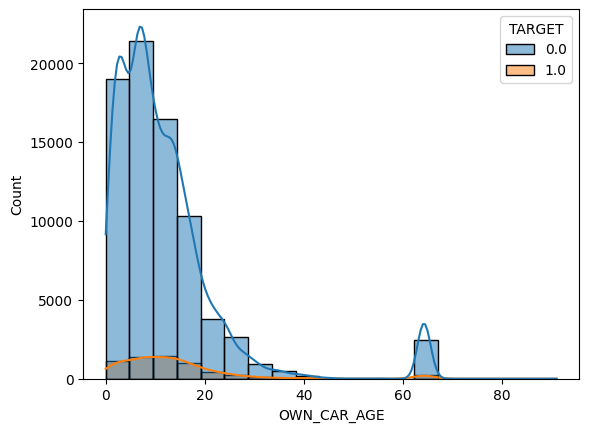

In [207]:
plot_histogram(df, 'OWN_CAR_AGE')

# OWN_CAR_AGE
+ The age of customer vehicles is primarily concentrated in the range of 0 to 20 years old, with the highest concentration being under 10 years old, indicating that most of the customer's vehicles are relatively new.

+ There is a small number of vehicles with significantly older ages (at ages 40, 60, and over 70 years old).

+ Customers who own newer vehicles are more likely to default on their debts compared to customers who own older vehicles, particularly those with vehicles that are 20 years old or older.


In [208]:
region_rating_data = df[['TARGET', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY' ]]
region_rating_corr = region_rating_data.corr()
region_rating_corr

,TARGET,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY
TARGET,1.000000,0.058058,0.060598
REGION_RATING_CLIENT,0.058058,1.000000,0.950842
REGION_RATING_CLIENT_W_CITY,0.060598,0.950842,1.000000


# 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY'

+ 'REGION_RATING_CLIENT' and 'REGION_RATING_CLIENT_W_CITY' have a high correlation coefficient of 0.95.
+ 'REGION_RATING_CLIENT_W_CITY' has a higher correlation (0.6) with the 'TARGET' variable.

=> dropping the 'REGION_RATING_CLIENT' column and retaining the 'REGION_RATING_CLIENT_W_CITY' column 

In [209]:
df['REGION_RATING_CLIENT_W_CITY'].value_counts()

2    229484
3     43860
1     34167
Name: REGION_RATING_CLIENT_W_CITY, dtype: int64

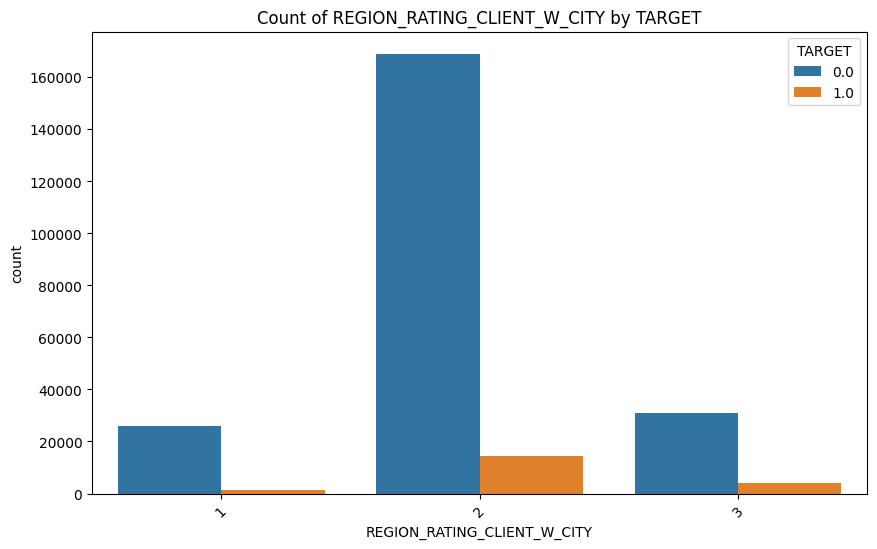

In [210]:
columns_to_plot = ['REGION_RATING_CLIENT_W_CITY']
plot_count_by_target_bar(df, columns_to_plot, 'TARGET')

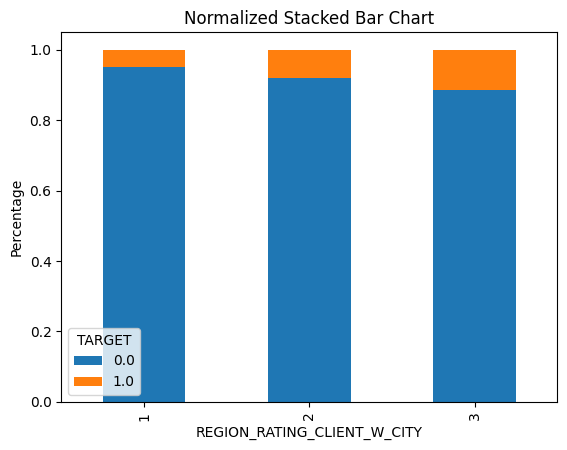

In [211]:
def plot_normalized_stacked_bar_chart(data, category_col, binary_col):
    grouped = data.groupby(category_col)[binary_col].value_counts(normalize=True).unstack()
    grouped.plot(kind='bar', stacked=True)
    plt.title('Normalized Stacked Bar Chart')
    plt.xlabel(category_col)
    plt.ylabel('Percentage')
    plt.show()


plot_normalized_stacked_bar_chart(df, 'REGION_RATING_CLIENT_W_CITY', 'TARGET')


# REGION_RATING_CLIENT_W_CITY:

+ Most customers belong to rating group 2, so this group also has the highest number of customers with loan defaults compared to the other two groups.
+ The uneven distribution among the rating groups indicates differences in the demographic and economic characteristics of the three regions. Groups '1' and '3' have significantly fewer customers compared to group '2'.

--> This does not clearly show the default rate between the groups, so we use a Normalized Stacked Bar Chart to visualize the default rate more clearly among the groups by dividing the default rate (TARGET 1.0) by the total number of customers in each rating group.

+ After creating the Normalized Stacked Bar Chart:
    + Region 3 has a higher default rate compared to the other two regions, possibly because Region 3 has the lowest rating, indicating that the economic and financial conditions of customers in Region 3 may not be as favorable as those in the other two regions.
    + Next is Region 2, and Region 1 has the lowest default rate because Region 1 has the highest rating.

=> Customers in rating group 3 have a higher default rate compared to the other groups.

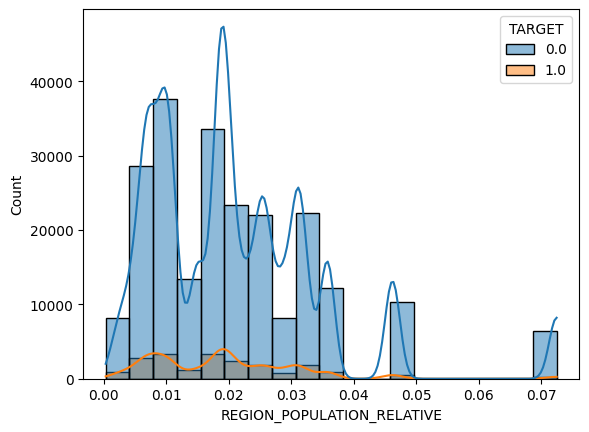

In [212]:
plot_histogram(df, 'REGION_POPULATION_RELATIVE')

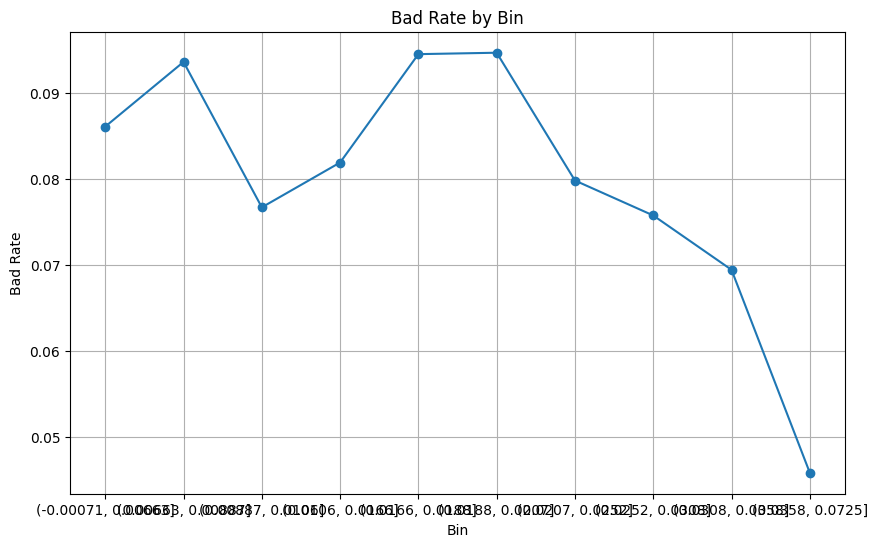

Numerical analysis of the trend:
RATIO_BIN
(-0.00071, 0.00663]         NaN
(0.00663, 0.00887]     0.007537
(0.00887, 0.0106]     -0.016950
(0.0106, 0.0166]       0.005226
(0.0166, 0.0188]       0.012632
(0.0188, 0.0207]       0.000166
(0.0207, 0.0252]      -0.014896
(0.0252, 0.0308]      -0.004073
(0.0308, 0.0358]      -0.006334
(0.0358, 0.0725]      -0.023654
Name: TARGET, dtype: float64


In [213]:
plot_bad_rate_trend(df, 'REGION_POPULATION_RELATIVE', num_bins=10)


# REGION_POPULATION_RELATIVE 

+ In areas with relatively high population density, the default rate is lower.


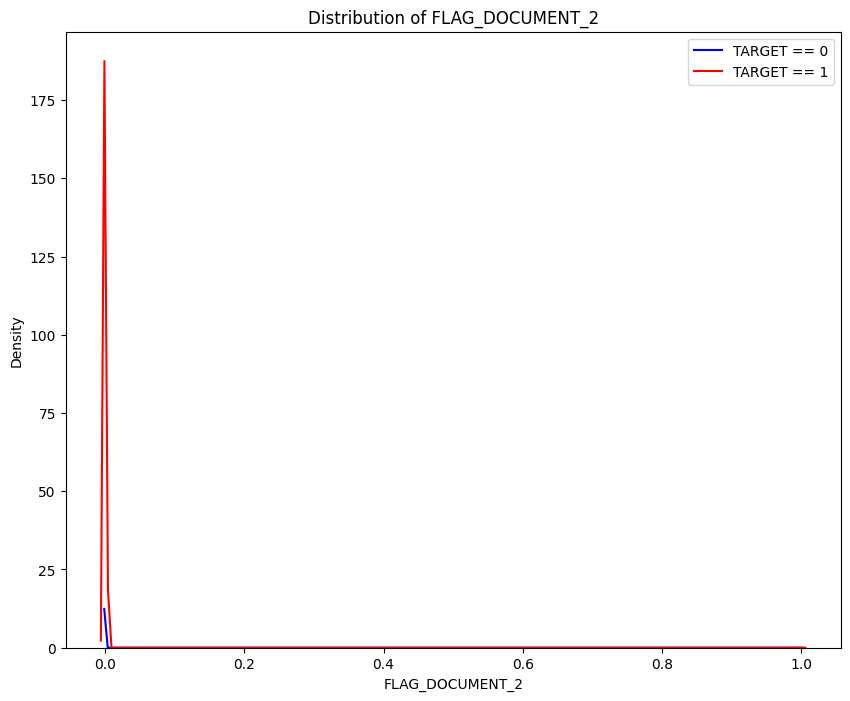

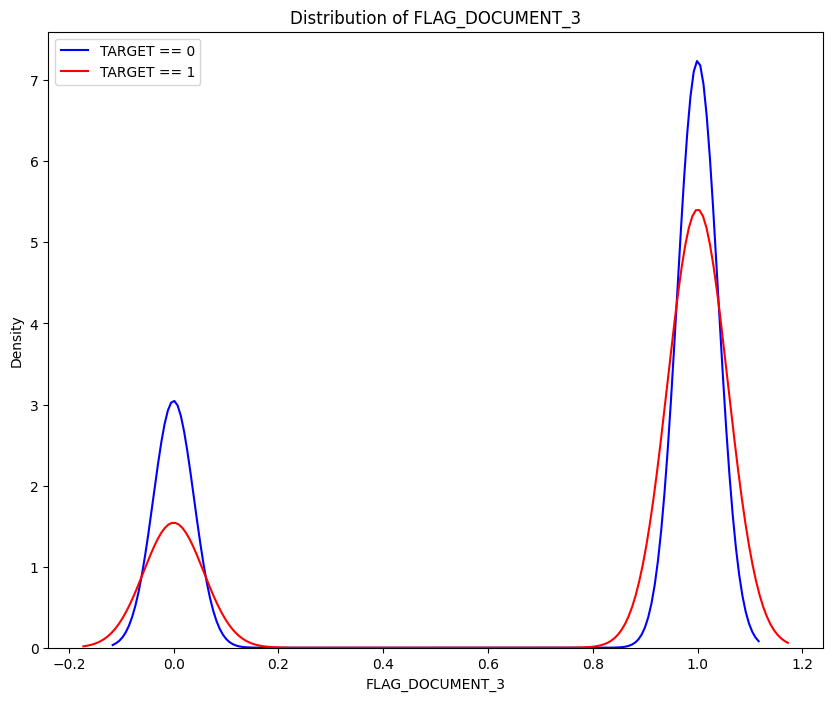

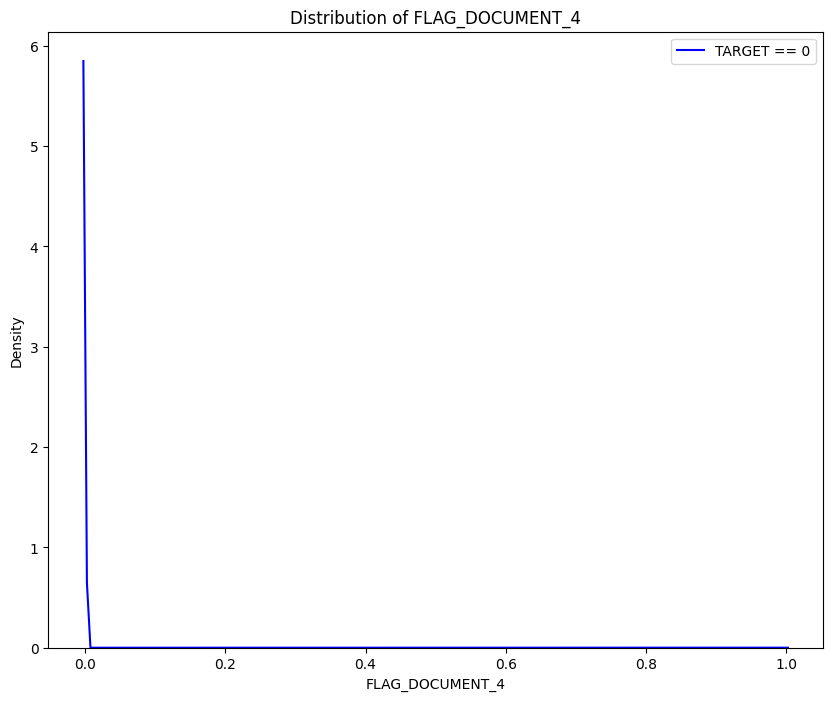

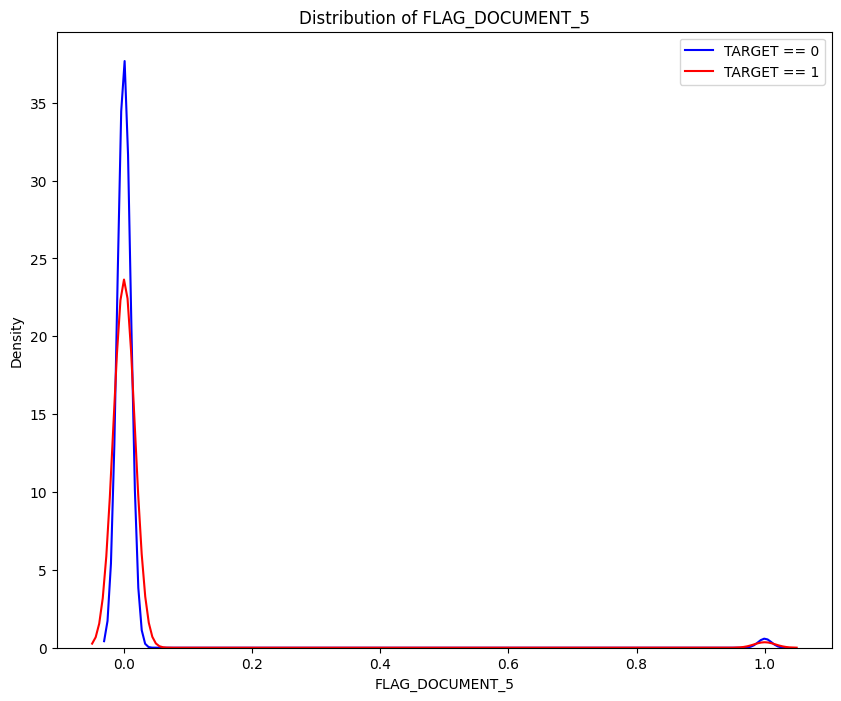

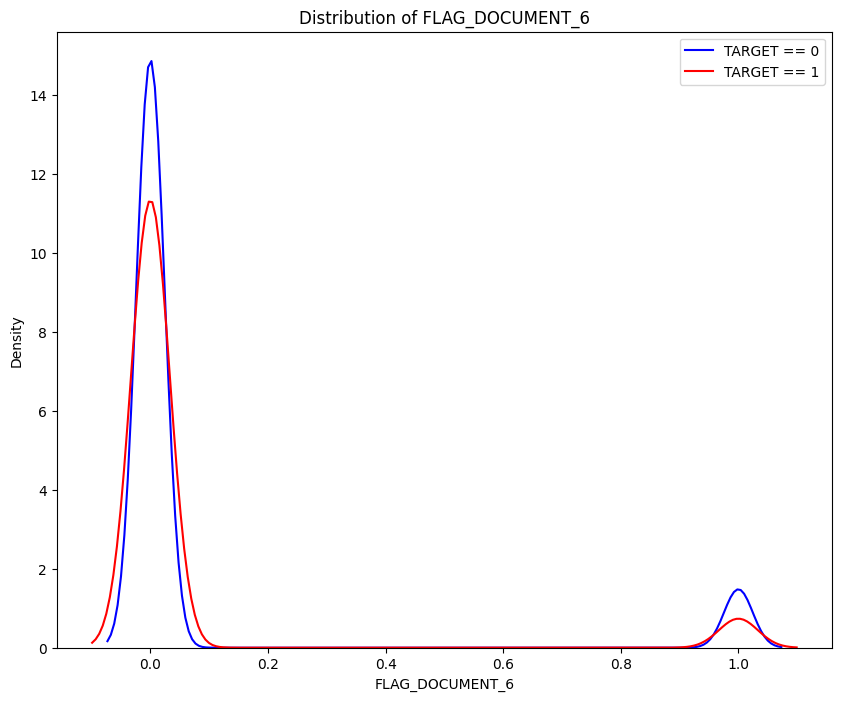

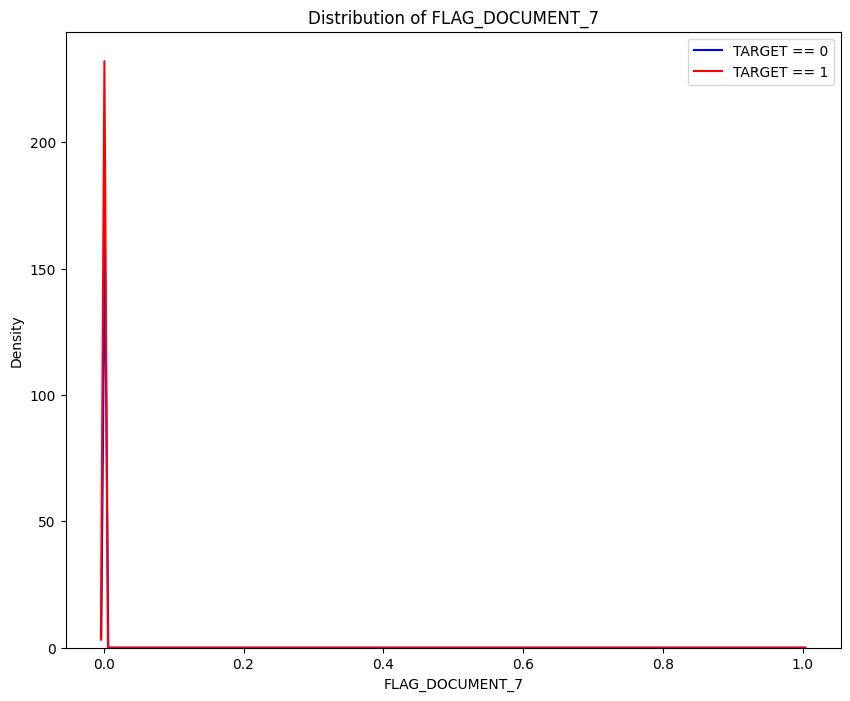

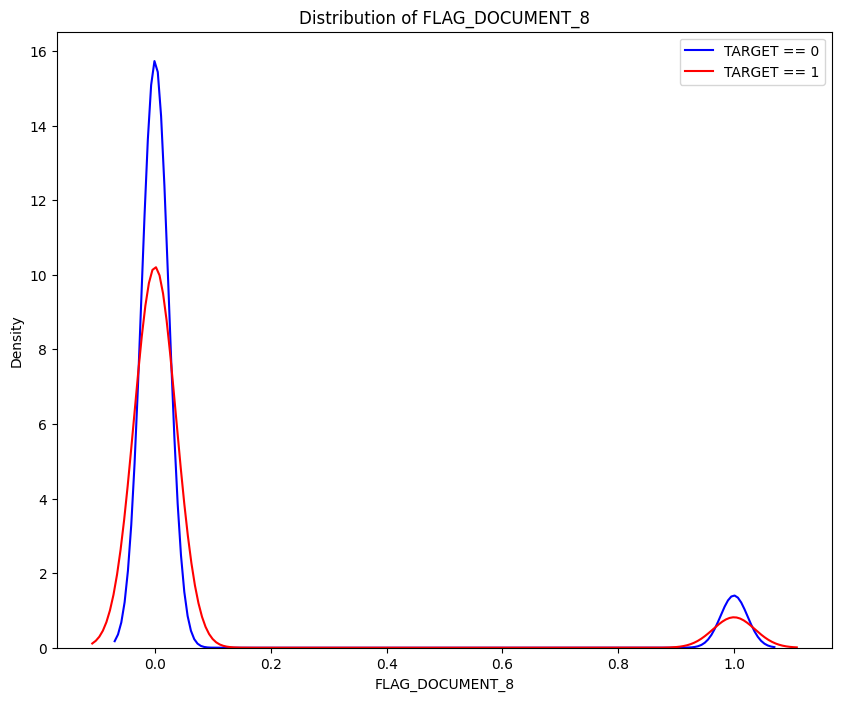

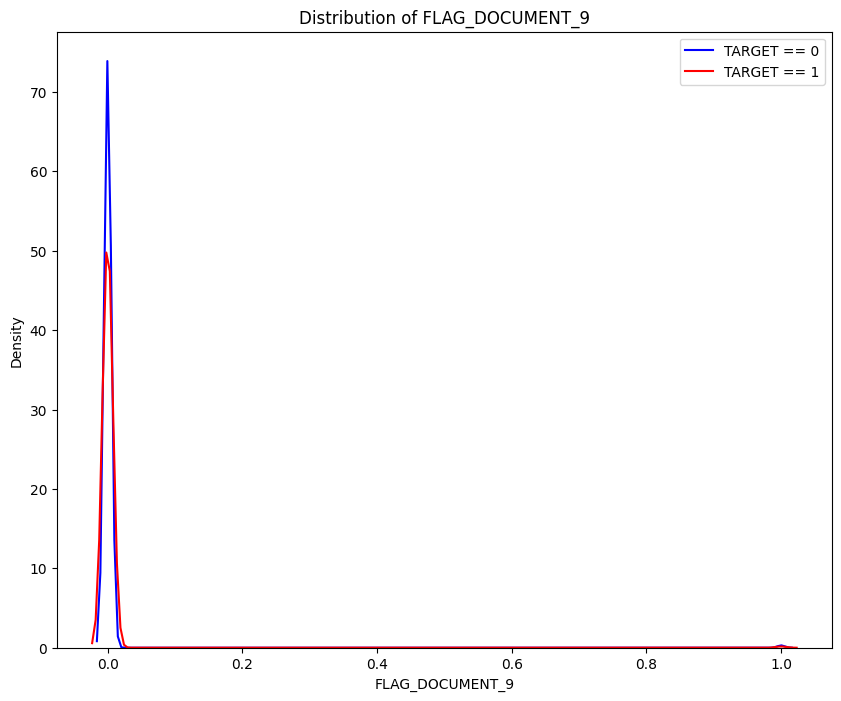

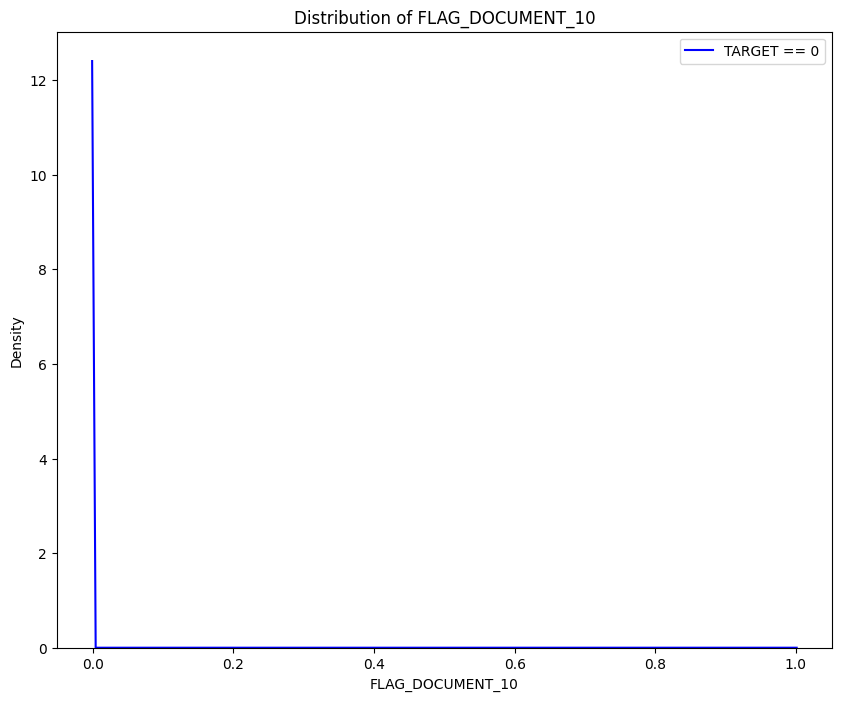

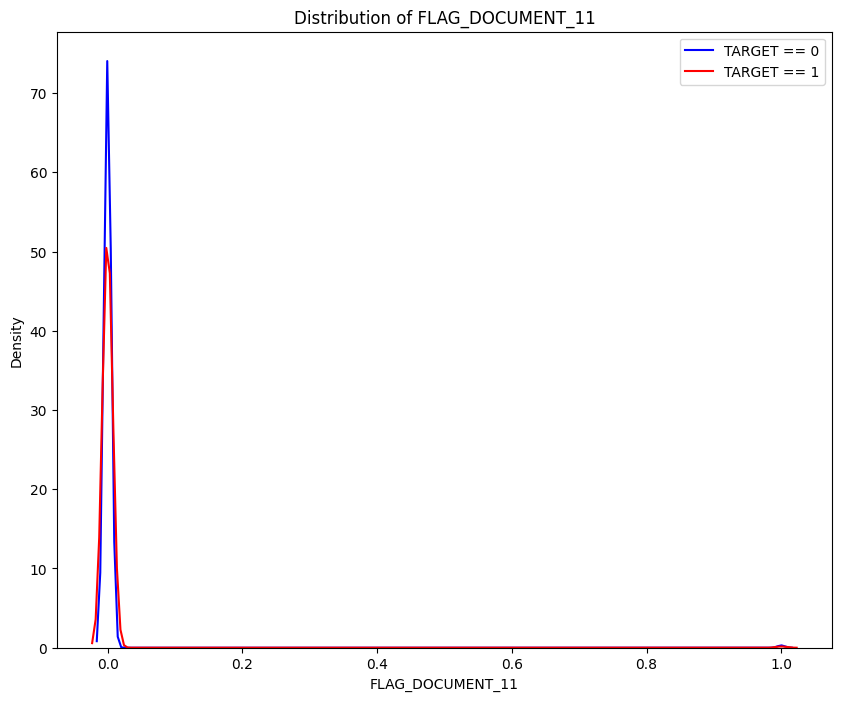

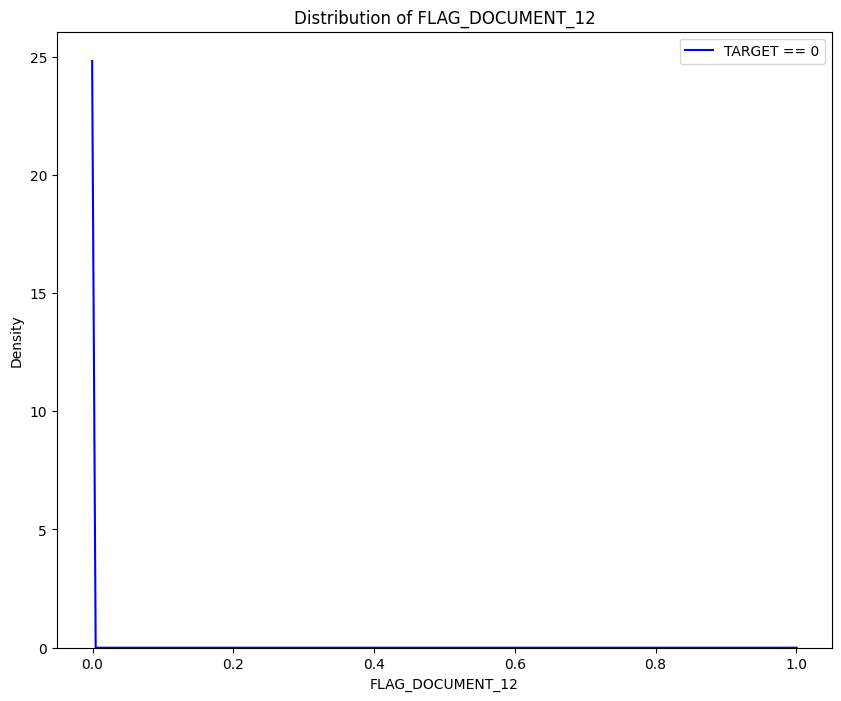

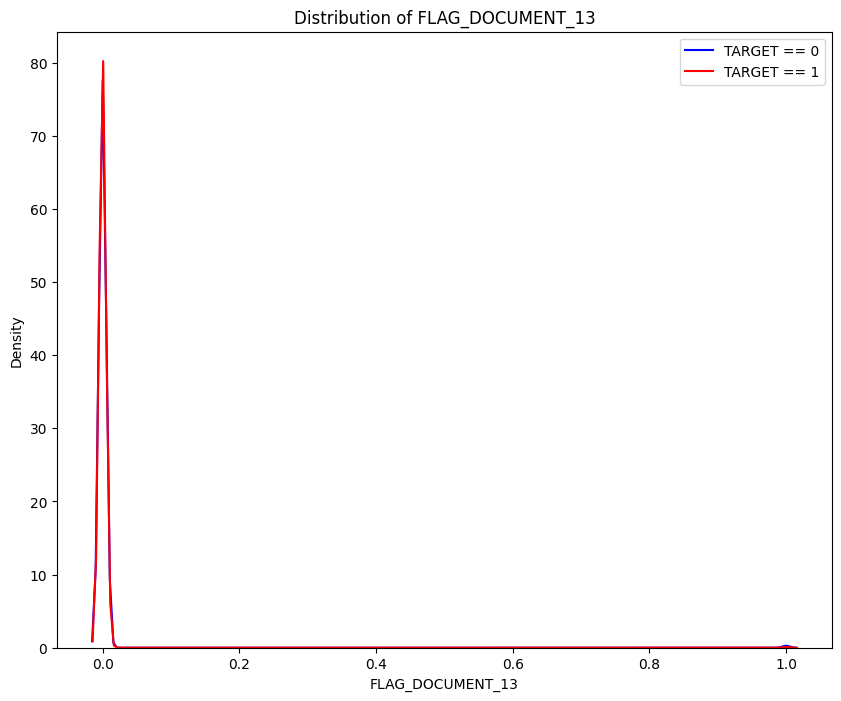

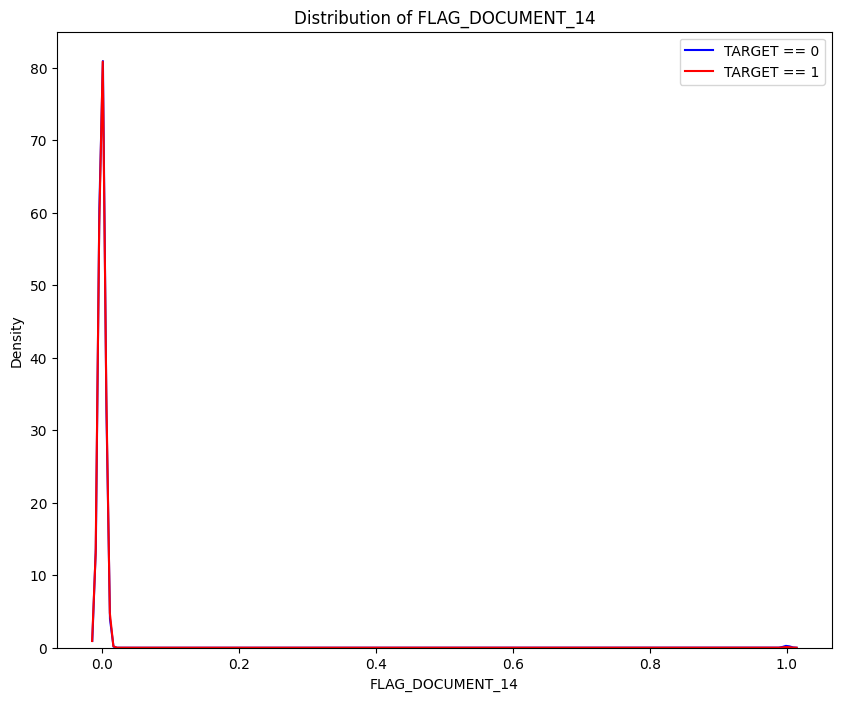

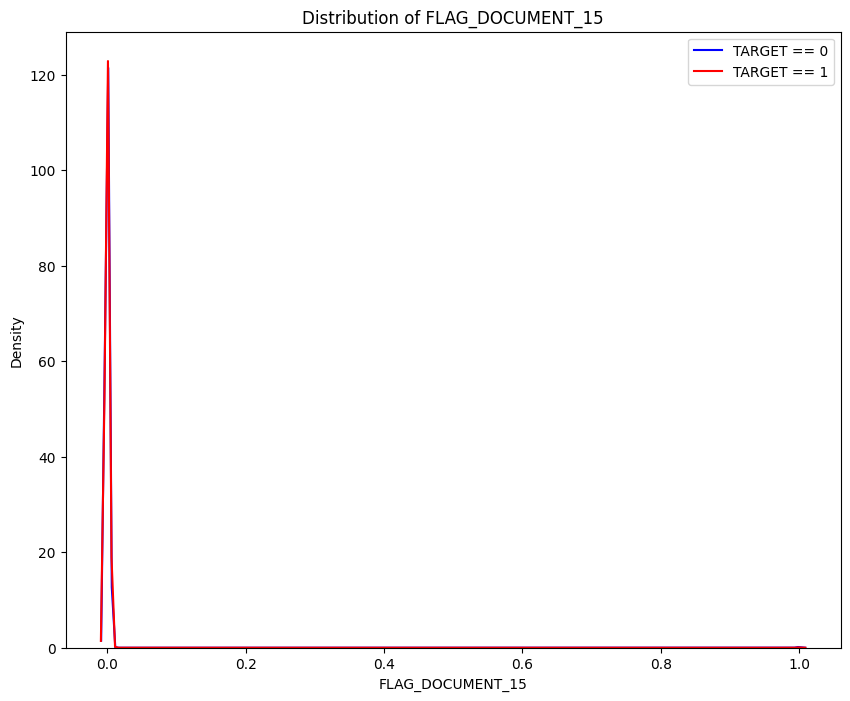

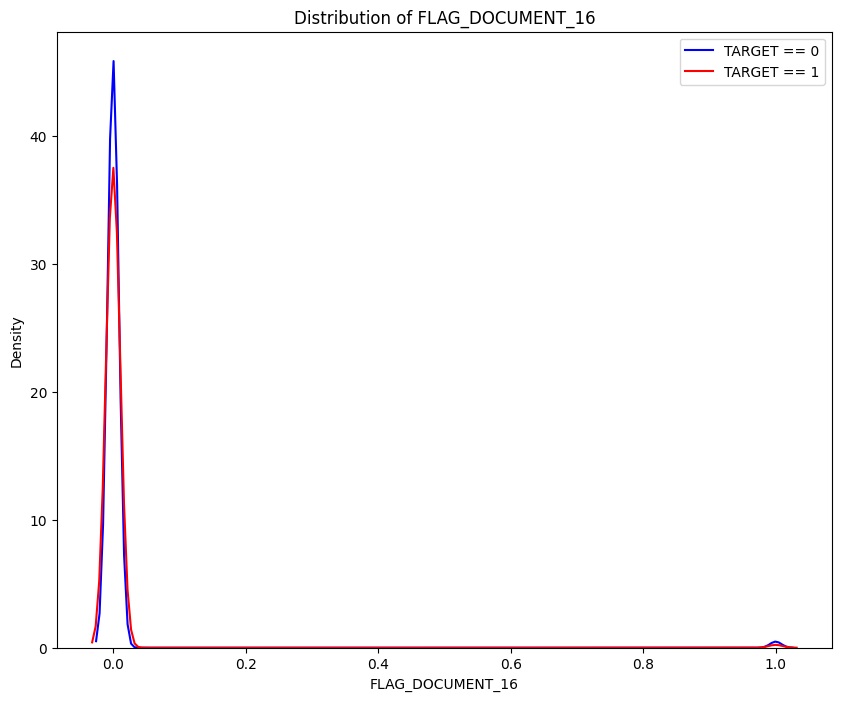

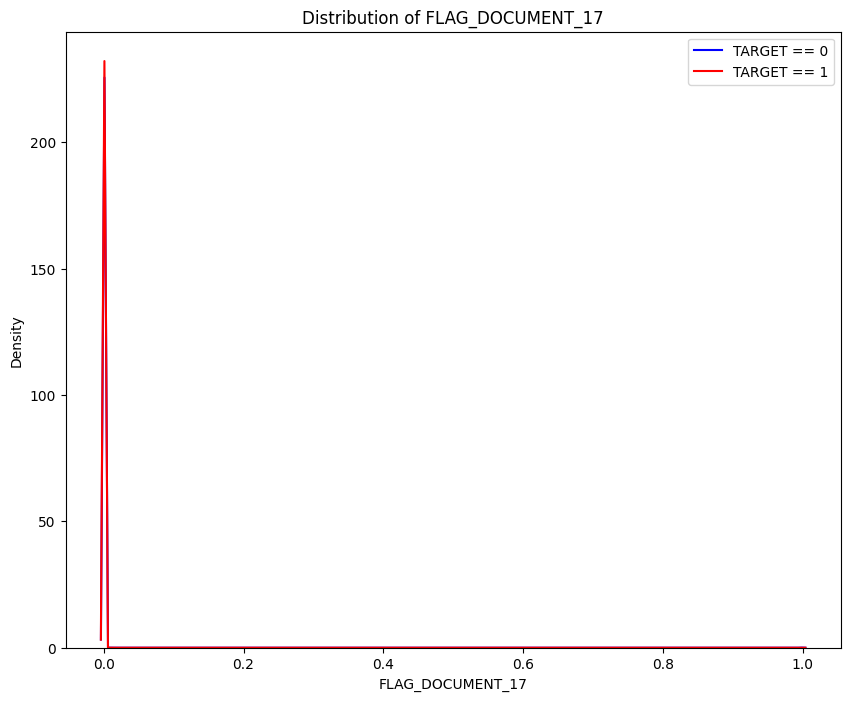

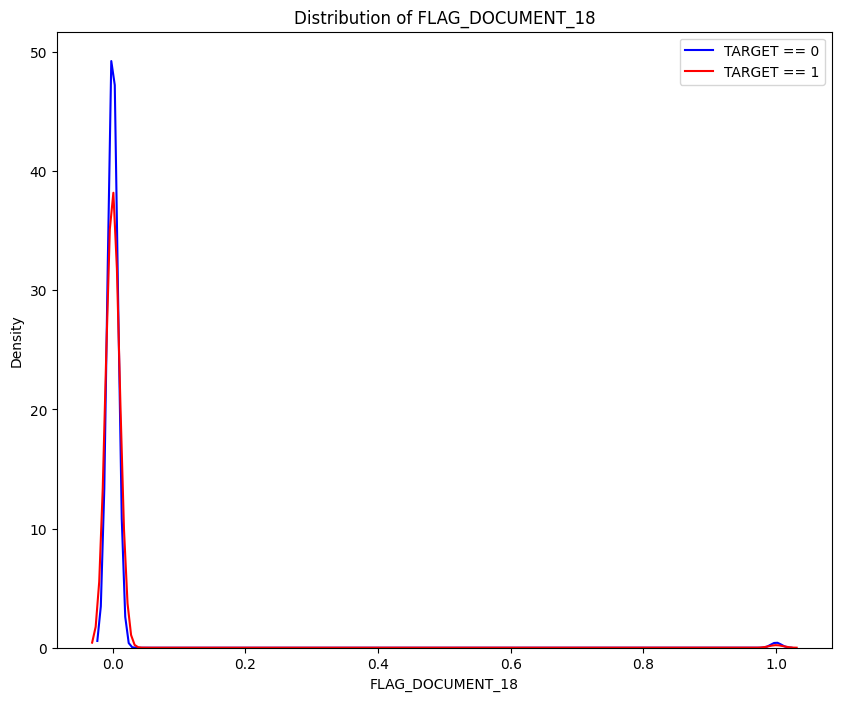

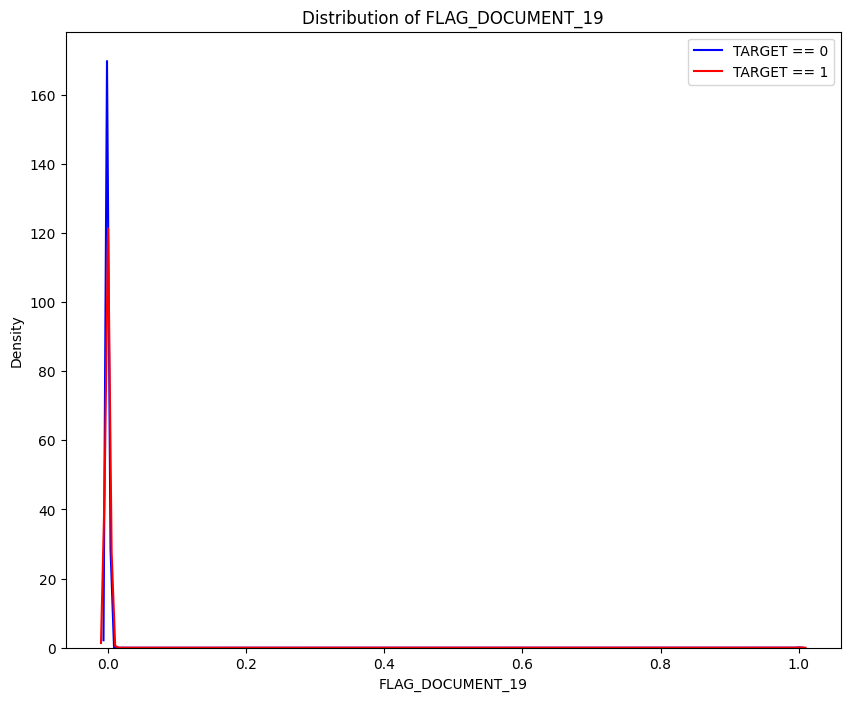

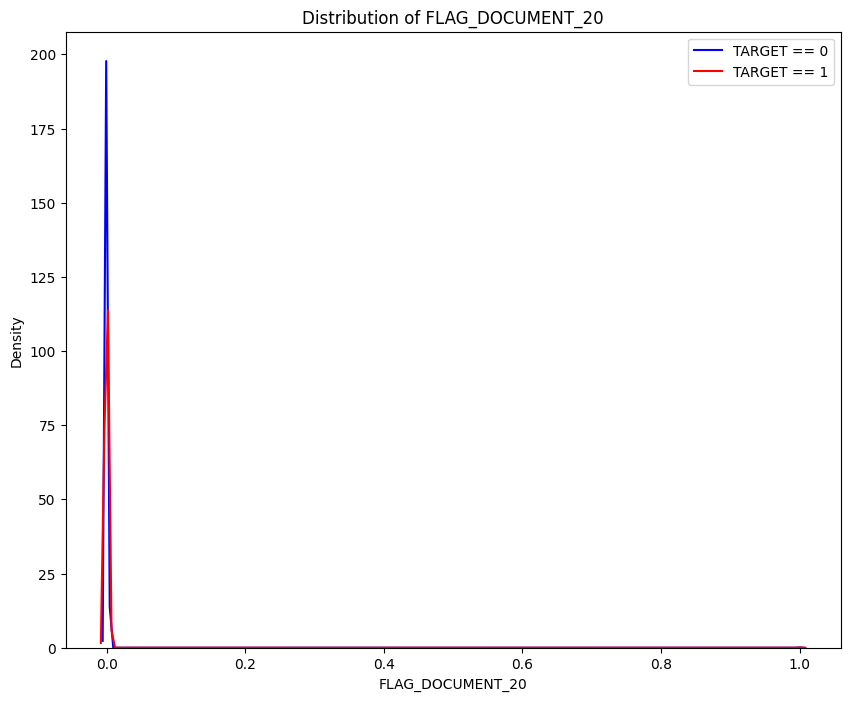

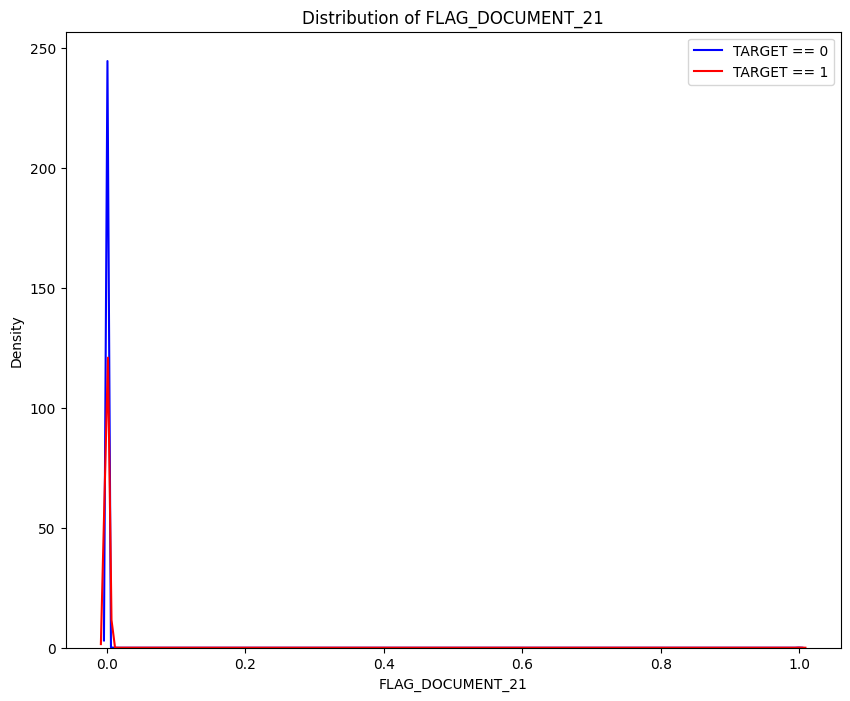

In [214]:
pattern = 'FLAG_DOCUMENT_'
matching_columns = [col for col in df.columns if col.startswith(pattern)]
for i in matching_columns:
    plot_distribution_by_target(df, i, 'TARGET')

# FALG DOCUMENT:

+ There is no clear differentiation between TARGET 1 and 0
+ To better distinguish between these two classes, you can create new features such as mean, standard deviation (std), kurtosis, sum, and max From the columns of the FLAG_DOCUMENT.
+ These new features may help provide more discriminatory information between the TARGET 1 and TARGET 0 classes. 

In [215]:
#     Create new features from document columns
docs = [f for f in df.columns if 'FLAG_DOC' in f]
df['NEW_DOC_IND_AVG'] = df[docs].mean(axis=1)
df['NEW_DOC_IND_STD'] = df[docs].std(axis=1)
df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)
df['DOCUMENT_COUNT'] = df[docs].sum(axis=1)
df['HAS_DOCUMENT'] = df[docs].max(axis=1)
# Drop most flag document columns
drop_list = []
for doc_num in [2,4,5,6,7,9,10,11,12,13,14,15,16,17,19,20,21]:
    drop_list.append('FLAG_DOCUMENT_{}'.format(doc_num))
df.drop(drop_list, axis=1, inplace=True)